In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
from lrg_plot_functions import *
from lrg_sum_functions import *
from cosmo_Calc import *
from divideByTwo import *
from read_data import *
from nearNeighbors import *
from scipy import stats
from astropy import stats
import healpy as hp
from localBKG_and_interlopersHEALPix import *
# import healpy as hpy
from makeCutoutTableFunc import *
from plotHistogramProjections3D import *
import os
import numpy as np
from astropy.table import Table, hstack
from scipy.spatial import cKDTree as KDTree

In [10]:
def read_isedfit():
    """Read the iSEDfit fitting results."""
    
#     parentfile = '/Users/mtownsend/anaconda/Data/lrg-survey-dr8-try5.fits'
    isedfile = '/Users/mtownsend/Downloads/lrgs_dr8_ckc14z_kroupa01_charlot_sfhgrid01.fits'
#     kcorrfile = '/Users/mtownsend/anaconda/Data/lrgs_ckc14z_kroupa01_charlot_sfhgrid01_kcorr.z0.0.fits'

#     print('Reading {}'.format(parentfile))
#     parent = Table.read(parentfile)
    print('Reading {}'.format(isedfile))
    ised = Table.read(isedfile)
#     print('Reading {}'.format(kcorrfile))
#     kcorr = Table.read(kcorrfile)
    
    snrmin = 3.0
    chi2min = 10
    
    keep = np.where(
        (ised['CHI2'] < chi2min) * 
        (np.sum(ised['MAGGIES'] * np.sqrt(ised['IVARMAGGIES']) > snrmin, axis=1) == 5)
    )[0]
    print('Read {} galaxies with chi2 < {} and S/N > {} in all 5 photometric bands.'.format(
        len(keep), chi2min, snrmin))
    
#     cat = dict()
#     cat['weight'] = len(keep) * parent['COUNT'][keep].data / np.sum(parent['COUNT'][keep].data)
#     cat['redshift'] = kcorr['Z'][keep].data
#     cat['Mstar'] = ised['MSTAR_50'][keep].data
#     cat['Mg'] = kcorr['ABSMAG'][keep, 0].data
#     cat['Mr'] = kcorr['ABSMAG'][keep, 1].data
#     cat['Mz'] = kcorr['ABSMAG'][keep, 2].data
#     cat['gr'] = cat['Mg'] - cat['Mr']
#     cat['rz'] = cat['Mr'] - cat['Mz']

#     with np.errstate(invalid='ignore'):
#         cat['grobs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 0].data / ised['MAGGIES'][keep, 1].data )
#         cat['rzobs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 1].data / ised['MAGGIES'][keep, 2].data )
#         cat['zW1obs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 2].data / ised['MAGGIES'][keep, 3].data )
     
    #mm = - 2.5 * np.log10(ised['MAGGIES'][keep, 0].data)
    #_ = plt.hist(mm, bins=100)
    
#     kcorr.remove_columns(['Z', 'ISEDFIT_ID', 'MAGGIES', 'IVARMAGGIES'])
    out = hstack([ised])
    
    return out

In [11]:
ised = read_isedfit()
ngal = len(ised)

Reading /Users/mtownsend/Downloads/lrgs_dr8_ckc14z_kroupa01_charlot_sfhgrid01.fits
Read 740800 galaxies with chi2 < 10 and S/N > 3.0 in all 5 photometric bands.


In [12]:
print(ngal)
ised[:5]

1078965


ISEDFIT_ID,RA,DEC,Z,MAGGIES [5],IVARMAGGIES [5],BESTMAGGIES [5],CHUNKINDX,MODELINDX,DELAYED,BURSTTYPE,CHI2,TOTALMASS,TOTALMASS_ERR,MSTAR,AGE,SFRAGE,TAU,ZMETAL,AV,MU,OIIIHB,NLYC,SFR,SFR100,B100,B1000,EWOII,EWOIIIHB,EWNIIHA,NBURST,TRUNCTAU,TBURST,DTBURST,FBURST,MSTAR_50,AGE_50,SFRAGE_50,TAU_50,ZMETAL_50,AV_50,MU_50,OIIIHB_50,SFR_50,SFR100_50,B100_50,B1000_50,EWOII_50,EWOIIIHB_50,EWNIIHA_50,MSTAR_AVG,AGE_AVG,SFRAGE_AVG,TAU_AVG,ZMETAL_AVG,AV_AVG,MU_AVG,OIIIHB_AVG,SFR_AVG,SFR100_AVG,B100_AVG,B1000_AVG,EWOII_AVG,EWOIIIHB_AVG,EWNIIHA_AVG,MSTAR_ERR,AGE_ERR,SFRAGE_ERR,TAU_ERR,ZMETAL_ERR,AV_ERR,MU_ERR,OIIIHB_ERR,SFR_ERR,SFR100_ERR,B100_ERR,B1000_ERR,EWOII_ERR,EWOIIIHB_ERR,EWNIIHA_ERR
int32,float64,float64,float32,float32,float32,float32,int16,int16,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0,37.92862397555869,-1.161706870298361,0.67909867,8.758764e-10 .. 3.521448e-08,1.8400667e+20 .. 4.1029328e+17,8.5453766e-10 .. 4.068169e-08,0,646,1,1,3.3725965,856121740000.0,5625974000.0,11.716446,6.9197736,6.7283525,0.09570866,0.013521288,0.406731,0.2539062,-1.0,52.25331,-3.0674648,-3.0674648,-15.0,-15.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,11.714107,6.852187,6.7283525,0.100916214,0.013521288,0.406731,0.27063605,-1.0,-3.0698042,-3.0698042,-15.0,-15.0,-1.0,-1.0,-1.0,11.685022,6.5373616,6.217908,0.15982851,0.013938655,0.36642438,0.32161894,-1.0,-2.883374,-2.9752085,-12.988878,-12.746897,-1.0,-1.0,-1.0,0.0473063,0.691841,0.7367016,0.15706308,0.0016931291,0.15224552,0.10111185,0.0,0.7654195,0.52829623,2.9617014,3.047122,0.0,0.0,0.0
1,37.36433263365962,-0.5526036281833835,0.58823,1.0108094e-09 .. 3.5016896e-08,1.756022e+20 .. 4.1662062e+17,1.1007772e-09 .. 3.577936e-08,0,2340,1,1,0.5872936,655970600000.0,3975141000.0,11.598271,7.552701,7.351299,0.100700654,0.010581199,0.92989254,0.3127259,-1.0,52.18259,-3.183116,-3.183116,-15.0,-15.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,11.525414,6.852187,6.0498047,0.24326818,0.016210476,0.27576527,0.3127259,-1.0,-3.229599,-3.2332754,-11.289713,-10.224919,-1.0,-1.0,-1.0,11.510478,6.576889,6.035269,0.27105987,0.015960611,0.39563385,0.34368062,-1.0,-2.5882602,-2.916991,-10.46587,-10.0402775,-1.0,-1.0,-1.0,0.06223297,0.8511988,0.9279564,0.185541,0.0040946673,0.30413774,0.11226401,0.0,0.78411436,0.5529258,2.993179,3.1165295,0.0,0.0,0.0
2,36.14626661726619,-1.0471812065670618,0.57408994,2.2709878e-09 .. 4.1128153e-08,2.2029595e+20 .. 4.574978e+17,2.4056281e-09 .. 4.5368484e-08,0,96,1,1,4.3237314,375537800000.0,2160053200.0,11.354112,4.4932547,2.601672,1.1316091,0.025259817,1.2715038,0.7490966,-1.0,54.403122,1.4036493,0.82411575,-1.0979775,-0.91137516,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,11.45475,7.364327,3.860954,1.6016691,0.025259817,1.2715038,0.714047,-1.0,1.403903,0.82436943,-1.0979775,-0.91137516,-1.0,-1.0,-1.0,11.420673,6.332656,3.5401685,1.8138689,0.024062939,1.4035059,0.6906544,-1.0,1.3938854,0.8449945,-1.0315427,-0.8950097,-1.0,-1.0,-1.0,0.04415536,1.062475,0.64251024,0.6130794,0.0038481816,0.21829808,0.0847875,0.0,0.13588428,0.20799923,0.21570073,0.17660852,0.0,0.0,0.0
3,37.83887909073174,0.8529345319035284,0.77483577,1.1353731e-09 .. 5.8114253e-08,1.6420305e+20 .. 4.273587e+17,1.0276312e-09 .. 6.434959e-08,0,4135,1,1,5.2646275,1035910300000.0,4798534000.0,11.81159,3.9778688,3.6049159,0.18647714,0.009885669,0.9766792,0.29984018,-1.0,52.134842,-2.9846783,-2.9846783,-7.8135657,-6.3376775,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,11.811732,4.3878155,3.6049159,0.2689638,0.012683684,0.6880155,0.29984018,-1.0,-0.92848

In [13]:
print(type(ised))

mstar = np.array(ised['MSTAR'])
print(type(mstar))

ra_MOUS = np.array(ised['RA'])
dec_MOUS = np.array(ised['DEC'])
mstar_err = np.array(ised['MSTAR_ERR'])
z_MOUS = np.array(ised['Z'])
print(len(ra_MOUS))
print(len(z_MOUS))

<class 'astropy.table.table.Table'>
<class 'numpy.ndarray'>
1078965
1078965


11.38707


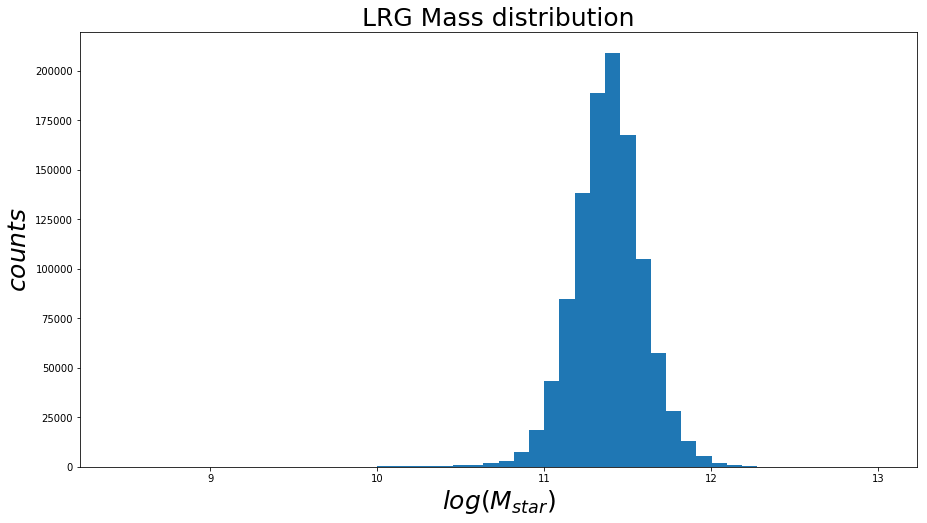

8.448975
13.006269
668


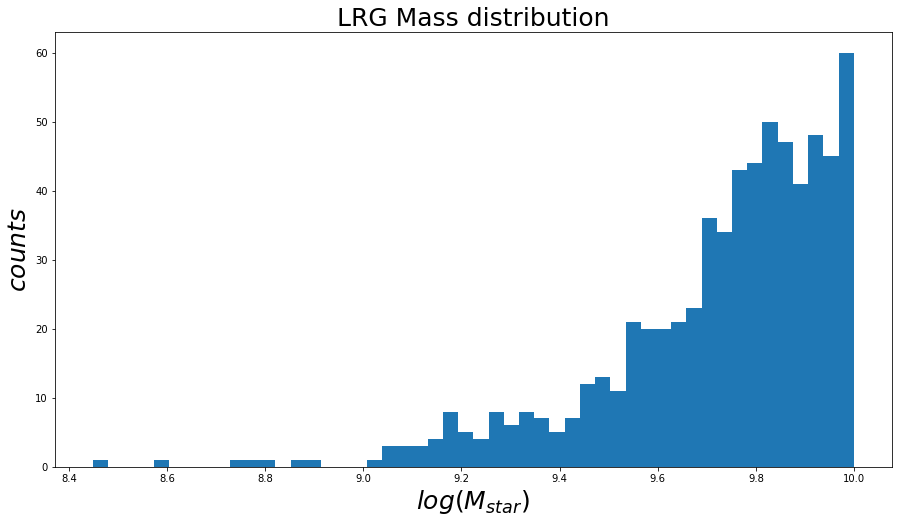

In [41]:
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend

print(np.median(mstar))

plt.rcParams["figure.figsize"] = [15, 8]
plt.title("LRG Mass distribution", fontsize=25)
plt.hist(mstar[np.where(mstar > 0)], bins=50)
# plt.axvline(linewidth=1, color='r')
plt.xlabel(r'$log(M_{star})$', fontsize=25)
plt.ylabel(r'$counts$', fontsize=25)
plt.show()

mstar_good = mstar[np.where(mstar > -1)]
print(min(mstar_good))
print(max(mstar_good))
print(len(mstar_good[np.where(mstar_good < 10)]))


plt.rcParams["figure.figsize"] = [15, 8]
plt.title("LRG Mass distribution", fontsize=25)
plt.hist(mstar_good[np.where(mstar_good < 10)], bins=50)
# plt.axvline(linewidth=1, color='r')
plt.xlabel(r'$log(M_{star})$', fontsize=25)
plt.ylabel(r'$counts$', fontsize=25)
plt.show()

In [7]:
# Reads in data files for use in readData.py

hdu_north = fits.open('/Users/mtownsend/anaconda/Data/survey-dr8-north-specObj-dr14.fits') # this matches SDSS LRGs to MzLS/BASS;
                                                                 # ONLY GIVES SOURCES THAT ARE IN SDSS and LEGACY SURVEYS
hdu_south = fits.open('//Users/mtownsend/anaconda/Data/survey-dr8-south-specObj-dr14.fits')# this matches SDSS LRGs to DECaLS;
                                                                 # ONLY GIVES SOURCES THAT ARE IN SDSS and LEGACY SURVEYS
hdu_sdss = fits.open('/Users/mtownsend/anaconda/Data/specObj-dr14.fits') # this is SDSS redshifts etc for LRGs
hdu_sweep1 = fits.open('/Users/mtownsend/anaconda/Data/sweep-240p005-250p010-dr8.fits') # this is one sweep file of the DECaLS data
hdu_sweep2 = fits.open('/Users/mtownsend/anaconda/Data/sweep-240p010-250p015-dr8.fits') # this is one sweep file of the DECaLS data

SpecObj_data_north = hdu_north[1].data
SpecObj_data_south = hdu_south[1].data
SDSS_data = hdu_sdss[1].data
DECaLS_data1 = hdu_sweep1[1].data
DECaLS_data2 = hdu_sweep2[1].data

id_LRG1, specobjid_LRG1, ra_LRG1, dec_LRG1, ra_BKG1, dec_BKG1, z_LRG1, gflux_LRG1, rflux_LRG1, zflux_LRG1, w1flux_LRG1, w2flux_LRG1, w3flux_LRG1, w4flux_LRG1, gflux_BKG1, rflux_BKG1, zflux_BKG1, w1flux_BKG1, w2flux_BKG1, w3flux_BKG1, w4flux_BKG1, gflux_ivar_LRG1, rflux_ivar_LRG1, zflux_ivar_LRG1, w1flux_ivar_LRG1, w2flux_ivar_LRG1, w3flux_ivar_LRG1, w4flux_ivar_LRG1, gflux_ivar_BKG1, rflux_ivar_BKG1, zflux_ivar_BKG1, w1flux_ivar_BKG1, w2flux_ivar_BKG1, w3flux_ivar_BKG1, w4flux_ivar_BKG1, mw_transmission_g_LRG1, mw_transmission_r_LRG1, mw_transmission_z_LRG1, mw_transmission_g_BKG1, mw_transmission_r_BKG1, mw_transmission_z_BKG1, mw_transmission_w1_LRG1, mw_transmission_w2_LRG1, mw_transmission_w3_LRG1, mw_transmission_w4_LRG1, mw_transmission_w1_BKG1, mw_transmission_w2_BKG1, mw_transmission_w3_BKG1, mw_transmission_w4_BKG1 = readData(SpecObj_data_south, SDSS_data, DECaLS_data1)
id_LRG2, specobjid_LRG2, ra_LRG2, dec_LRG2, ra_BKG2, dec_BKG2, z_LRG2, gflux_LRG2, rflux_LRG2, zflux_LRG2, w1flux_LRG2, w2flux_LRG2, w3flux_LRG2, w4flux_LRG2, gflux_BKG2, rflux_BKG2, zflux_BKG2, w1flux_BKG2, w2flux_BKG2, w3flux_BKG2, w4flux_BKG2, gflux_ivar_LRG2, rflux_ivar_LRG2, zflux_ivar_LRG2, w1flux_ivar_LRG2, w2flux_ivar_LRG2, w3flux_ivar_LRG2, w4flux_ivar_LRG2, gflux_ivar_BKG2, rflux_ivar_BKG2, zflux_ivar_BKG2, w1flux_ivar_BKG2, w2flux_ivar_BKG2, w3flux_ivar_BKG2, w4flux_ivar_BKG2, mw_transmission_g_LRG2, mw_transmission_r_LRG2, mw_transmission_z_LRG2, mw_transmission_g_BKG2, mw_transmission_r_BKG2, mw_transmission_z_BKG2, mw_transmission_w1_LRG2, mw_transmission_w2_LRG2, mw_transmission_w3_LRG2, mw_transmission_w4_LRG2, mw_transmission_w1_BKG2, mw_transmission_w2_BKG2, mw_transmission_w3_BKG2, mw_transmission_w4_BKG2 = readData(SpecObj_data_south, SDSS_data, DECaLS_data2)


print("end readdata")

done reading in SDSS
done reading in DECaLS-SDSS matched file
done creating unique IDs for matched file
done making LRG only cut
done reading in DECaLS bricks
length of id_ALL:  4488579
done creating unique IDs for brick file
done identifying LRGs in survey brick
631147
done making survey cuts
done reading in SDSS
done reading in DECaLS-SDSS matched file
done creating unique IDs for matched file
done making LRG only cut
done reading in DECaLS bricks
length of id_ALL:  4076998
done creating unique IDs for brick file
done identifying LRGs in survey brick
249137
done making survey cuts
end readdata


In [23]:
# calculate LRG magnitudes

gmag_LRG_nocuts = 22.5 - 2.5 * np.log10(gflux_LRG1)
rmag_LRG_nocuts = 22.5 - 2.5 * np.log10(rflux_LRG1)
zmag_LRG_nocuts = 22.5 - 2.5 * np.log10(zflux_LRG1)

# calculate BKG magnitudes

gmag_BKG1 = 22.5 - 2.5 * np.log10(gflux_BKG1)
gmag_BKG2 = 22.5 - 2.5 * np.log10(gflux_BKG2)
rmag_BKG1 = 22.5 - 2.5 * np.log10(rflux_BKG1)
rmag_BKG2 = 22.5 - 2.5 * np.log10(rflux_BKG2)
zmag_BKG1 = 22.5 - 2.5 * np.log10(zflux_BKG1)
zmag_BKG2 = 22.5 - 2.5 * np.log10(zflux_BKG2)

gmag_BKG_nocuts = np.concatenate([gmag_BKG1, gmag_BKG2])
rmag_BKG_nocuts = np.concatenate([rmag_BKG1, rmag_BKG2])
zmag_BKG_nocuts = np.concatenate([zmag_BKG1, zmag_BKG2])
    
# calculate LRG (g-r) and (r-z) colors
    
grcolor_LRG_nocuts = gmag_LRG_nocuts - rmag_LRG_nocuts
rzcolor_LRG_nocuts = rmag_LRG_nocuts - zmag_LRG_nocuts
    
# calculate BKG (g-r) and (r-z) colors
    
grcolor_BKG_nocuts = gmag_BKG - rmag_BKG
rzcolor_BKG_nocuts = rmag_BKG - zmag_BKG

# create full list of LRG attributes

ra_LRG_nocuts = ra_LRG1
ra_BKG_nocuts = np.concatenate([ra_BKG1, ra_BKG2])
dec_LRG_nocuts = dec_LRG1
dec_BKG_nocuts = np.concatenate([dec_BKG1, dec_BKG2])
z_LRG_nocuts = z_LRG1
id_LRG_nocuts = id_LRG1

ra_nocuts = np.concatenate([ra_LRG_nocuts, ra_BKG_nocuts])
dec_nocuts = np.concatenate([dec_LRG_nocuts, dec_BKG_nocuts])

# cut for zmag brighter than 22.75

ra_LRG = ra_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
dec_LRG = dec_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
id_LRG = id_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]

z_LRG = z_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.75))]

gmag_LRG = gmag_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
rmag_LRG = rmag_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
zmag_LRG = zmag_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
grcolor_LRG = grcolor_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
rzcolor_LRG = rzcolor_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]

ra_BKG = ra_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
dec_BKG = dec_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]

gmag_BKG = gmag_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
rmag_BKG = rmag_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
zmag_BKG = zmag_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
grcolor_BKG = grcolor_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
rzcolor_BKG = rzcolor_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]

# combine LRG and BKG lists

ra = np.concatenate([ra_LRG, ra_BKG])
dec = np.concatenate([dec_LRG, dec_BKG])

gmag = np.concatenate([gmag_LRG, gmag_BKG])
rmag = np.concatenate([rmag_LRG, rmag_BKG])
zmag = np.concatenate([zmag_LRG, zmag_BKG])

grcolor = np.concatenate([grcolor_LRG, grcolor_BKG]) 
rzcolor = np.concatenate([rzcolor_LRG, rzcolor_BKG]) 

In [24]:
from astropy.coordinates import SkyCoord, match_coordinates_sky                                   
from astropy import units as u       

mous_cat = SkyCoord(ra=ra_MOUS*u.degree, dec=dec_MOUS*u.degree)                          

my_cat = SkyCoord(ra=ra_LRG*u.degree, dec=dec_LRG*u.degree)                                

idx, sep2d, dist3d = match_coordinates_sky(my_cat, mous_cat, nthneighbor=1)
# idx, sep2d, dist3d = my_cat.match_to_catalog_sky(mous_cat)

print(ra_LRG[1])
print(ra_MOUS[idx[1]])

print(dec_LRG[1])
print(dec_MOUS[idx[1]])

mass_LRG = mstar[idx]
print(len(mass_LRG))

ra_cut = ra_MOUS[np.where((z_MOUS >= 0.2) & (z_MOUS <= 0.65) & (ra_MOUS >= 241) & (ra_MOUS <= 246) & (dec_MOUS >= 6.5) & (dec_MOUS <= 11.5))]
dec_cut = dec_MOUS[np.where((z_MOUS >= 0.2) & (z_MOUS <= 0.65) & (ra_MOUS >= 241) & (ra_MOUS <= 246) & (dec_MOUS >= 6.5) & (dec_MOUS <= 11.5))]
print(len(ra_cut))
print(len(ra_MOUS))


241.05811624717717
241.05811624717717
9.243933417459095
9.243933417459095
1823
1823
1078965


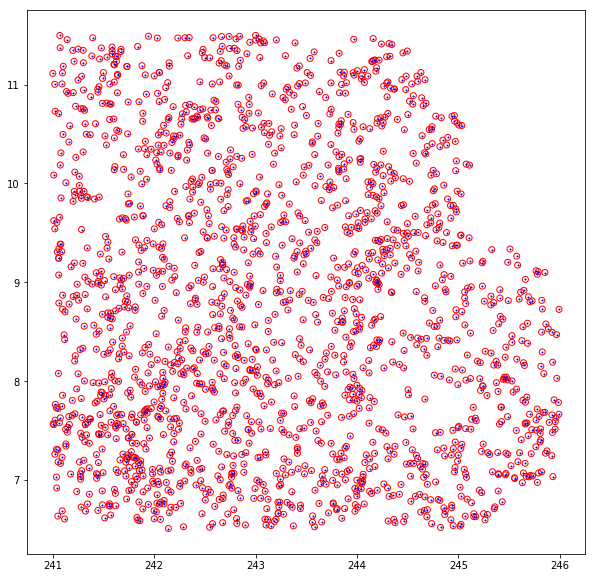

In [25]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.scatter(ra_MOUS[idx], dec_MOUS[idx], facecolors='none', edgecolors='r')
plt.scatter(ra_LRG, dec_LRG, c="blue", s=1)
# plt.scatter(ra_LRG, dec_LRG, c='blue')
plt.show()

In [26]:
DTT_Gyr, age_Gyr, zage_Gyr, DCMR_Mpc, DCMR_Gyr, DA_Mpc, DA_Gyr, kpc_DA, DL_Mpc, DL_Gyr, V_Gpc = cosmoCalcfunc(z_LRG)

print("end cosmoCalc")

end cosmoCalc


In [27]:
# H1, edges = np.histogramdd((rzcolor, zmag, grcolor), bins=30, range=((min(rzcolor), 29.), (min(zmag), 35.), (min(grcolor), 34.)), density=False)
H1, edges = np.histogramdd((rzcolor, zmag, grcolor), bins=50, density=False)

# make 2D projections of 3D histogram
rz_v_zmag = H1[:, :, :].sum(axis=2)
rz_vs_zmag = np.fliplr(rz_v_zmag)
gr_v_zmag = H1[:, :, :].sum(axis=0)
gr_vs_zmag = np.flipud(gr_v_zmag.T)
gr_v_rz = H1[:, :, :].sum(axis=1)
gr_vs_rz = np.flipud(gr_v_rz.T)

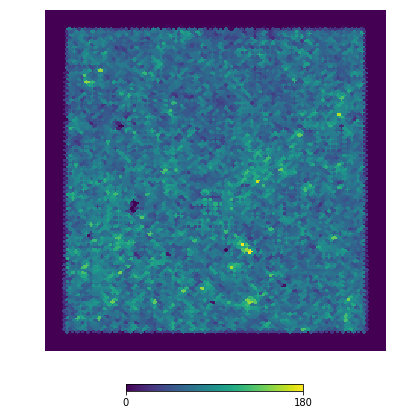

length phi:  519348


In [28]:
# Make HEALPix map using just RA/Dec; end up with a density plot

nside = 1024
npixel = hp.nside2npix(nside)

# Convert ra/dec into theta/phi
theta = []
phi = []

for i in range(len(ra)):
    theta.append(np.radians(90. - dec[i]))
    phi.append(np.radians(ra[i]))
    
m = hp.ang2pix(nside, theta, phi)
map_ = np.bincount(m, minlength=npixel)
hp.gnomview(map_, xsize=225, rot=(-116.5, 9), flip='geo', cmap='viridis', notext=True, title="")
# plt.rcParams.update({'font.size':20})
# plt.savefig('/Users/mtownsend/Desktop/survey-density.jpg')
# plt.savefig('/Users/mtownsend/Desktop/survey-density.pdf')
plt.show()

print('length phi: ', len(phi))

# Convert angles theta and phi to pixel numbers

pixnums = hp.ang2pix(nside, theta, phi, nest=True)


In [29]:
distance = 0.5 # must be in Mpc

distance_kpc, near, gal_tree, dist, index, nn1 = nearNeighbor(distance, kpc_DA, ra_LRG, dec_LRG, ra_BKG, dec_BKG, zmag_LRG, zmag_BKG, rzcolor_LRG, rzcolor_BKG, grcolor_LRG, grcolor_BKG, edges)

print('end nearNeighbor')

end nearNeighbor


mean number of near neighbors is 47.37410861217773
median number of near neighbors is 41.0
standard deviation of near neighbor is 23.851534505334982
standard error is 0.5587816536680068


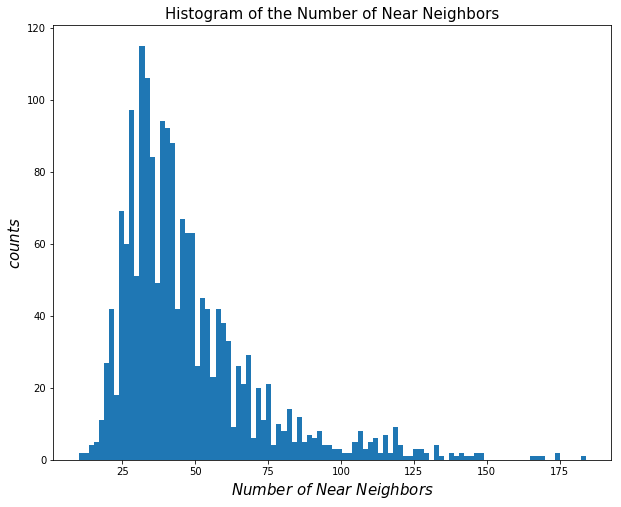

In [30]:
totalNear(near)

plt.show()

In [31]:
inner_dist = 0.4 # in deg
outer_dist = 0.5 # in deg

Nbkg, indices, omega, localBKG = localBKG_and_interlopersHEALPix(nside, inner_dist, outer_dist, ra_LRG, dec_LRG, pixnums, zmag, rzcolor, grcolor, edges, distance_kpc, kpc_DA)

omega = np.array(omega)

print("end bkg")


end bkg


mean number of interlopers is 36.4805991105871
median number of interlopers is 32.26296824728518
standard deviation of interloper is 17.29324268832587
standard error is 0.40513731913154255


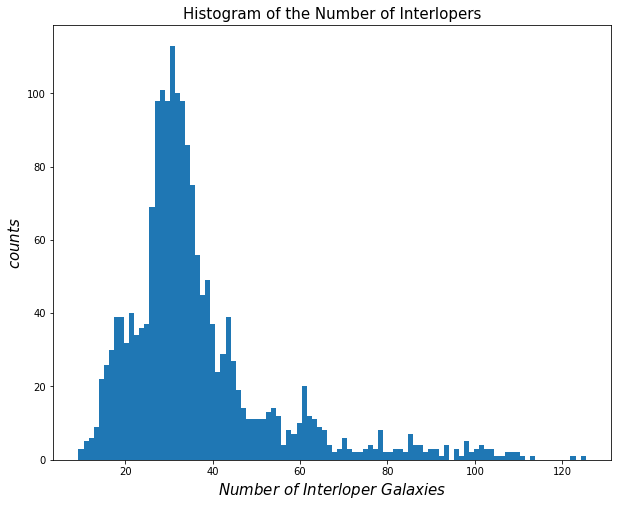

In [32]:
totalNbkg(Nbkg)

plt.show()

Nbkg = np.array(Nbkg)

In [33]:
Nsat = np.array(near) - np.array(Nbkg)

print("end Nsat")

end Nsat


mean number of satellites is 10.89350950159063
median number of satellites is 8.594618015771367
standard deviation of satellites is 16.107456135452438
standard error is 0.37735731316321813


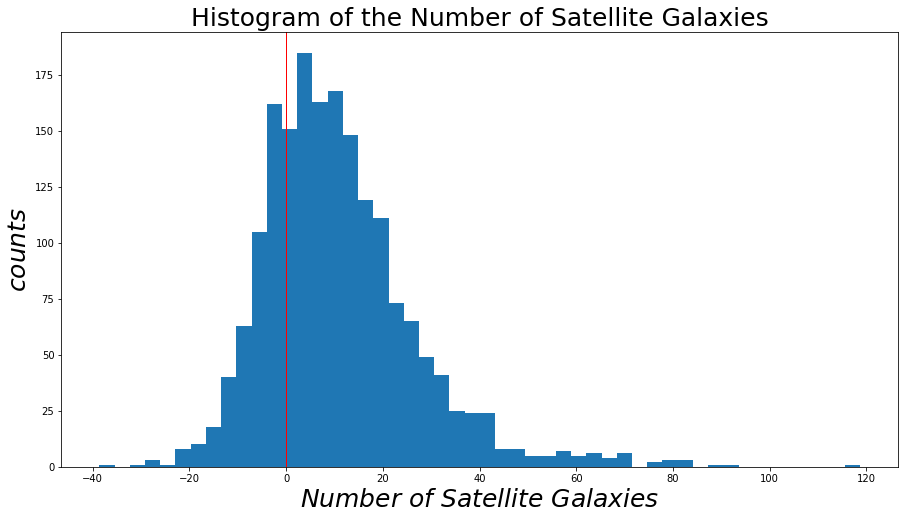

In [34]:
totalNsat(Nsat)

# plt.savefig('/Users/mtownsend/Desktop/Nsat.jpg')
plt.show()

In [35]:
sumsat, sumsat1z, sumsat2z, sumsat3z, sumsat4z, sumsat5z, sumsat6z, sumsat7z, sumsat1r, sumsat2r, sumsat3r, sumsat4r, sumsat5r, sumsat6r, sumsat7r, sumsat1g, sumsat2g, sumsat3g, sumsat4g, sumsat5g, sumsat6g, sumsat7g, sumsat8g, sumsat1_zmag, sumsat2_zmag, sumsat3_zmag, sumsat4_zmag, sumsat5_zmag, sumsat6_zmag, sumsat7_zmag  = sumNsat(Nsat, z_LRG, rmag_LRG, gmag_LRG, zmag_LRG)

sumnear, sumnear1z, sumnear2z, sumnear3z, sumnear4z, sumnear5z, sumnear6z, sumnear7z, sumnear1r, sumnear2r, sumnear3r, sumnear4r, sumnear5r, sumnear6r, sumnear7r, sumnear1g, sumnear2g, sumnear3g, sumnear4g, sumnear5g, sumnear6g, sumnear7g, sumnear8g, sumnear1_zmag, sumnear2_zmag, sumnear3_zmag, sumnear4_zmag, sumnear5_zmag, sumnear6_zmag, sumnear7_zmag = sumNN(near, z_LRG, rmag_LRG, gmag_LRG, zmag_LRG)

# print(sumsat)

sumsat = np.array(sumsat)

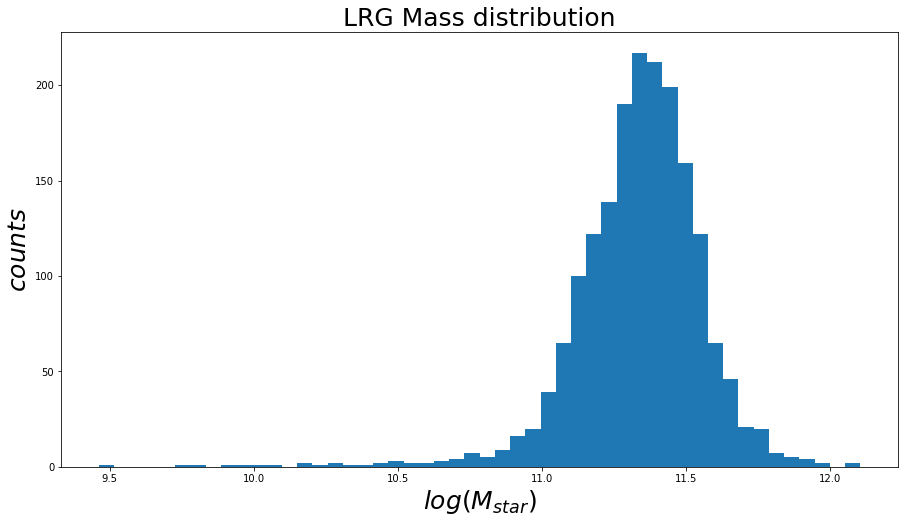

11.3511505


In [44]:
plt.rcParams["figure.figsize"] = [15, 8]
plt.title("LRG Mass distribution", fontsize=25)
plt.hist(mstar[idx], bins=50)
# plt.axvline(linewidth=1, color='r')
plt.xlabel(r'$log(M_{star})$', fontsize=25)
plt.ylabel(r'$counts$', fontsize=25)
plt.show()

print(np.median(mstar[idx]))

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sumsat_mstar1 = sumsat[np.where((mstar[idx] < 10.75))]
sumsat_mstar2 = sumsat[np.where((mstar[idx] >= 10.75) & (mstar[idx] < 11.35))]
sumsat_mstar3 = sumsat[np.where((mstar[idx] >= 11.35))]

print(len(sumsat_mstar1))
print(len(sumsat_mstar2))
print(len(sumsat_mstar3))


32
871
920


7.609594329425361


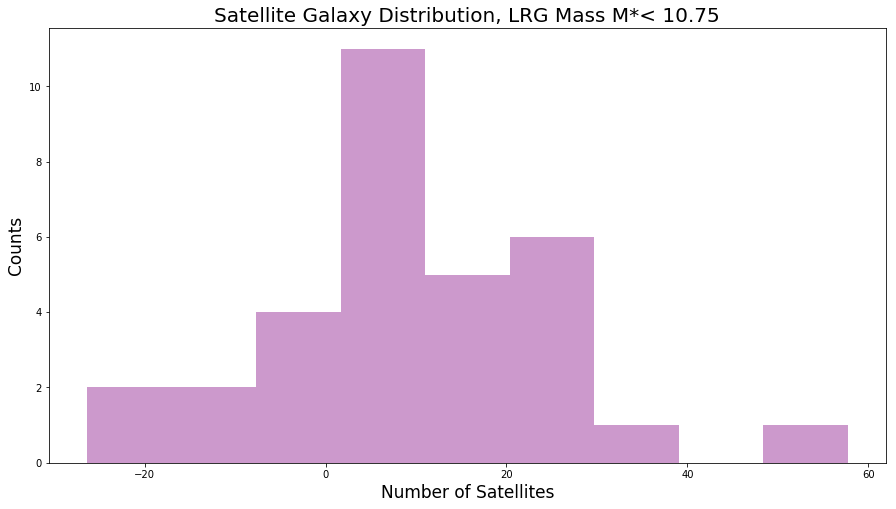

In [50]:
print(np.median(sumsat_mstar1))

sns.distplot(sumsat_mstar1, kde=False, color='purple')
plt.title('Satellite Galaxy Distribution, LRG Mass M*< 10.75', fontsize=20)
plt.xlabel('Number of Satellites', fontsize=17)
plt.ylabel('Counts', fontsize=17)
plt.savefig('/Users/mtownsend/Desktop/Nsat-dist-mstar1_v1.pdf')
plt.savefig('/Users/mtownsend/Desktop/Nsat-dist-mstar1_v1.jpg')



6.58289531257013


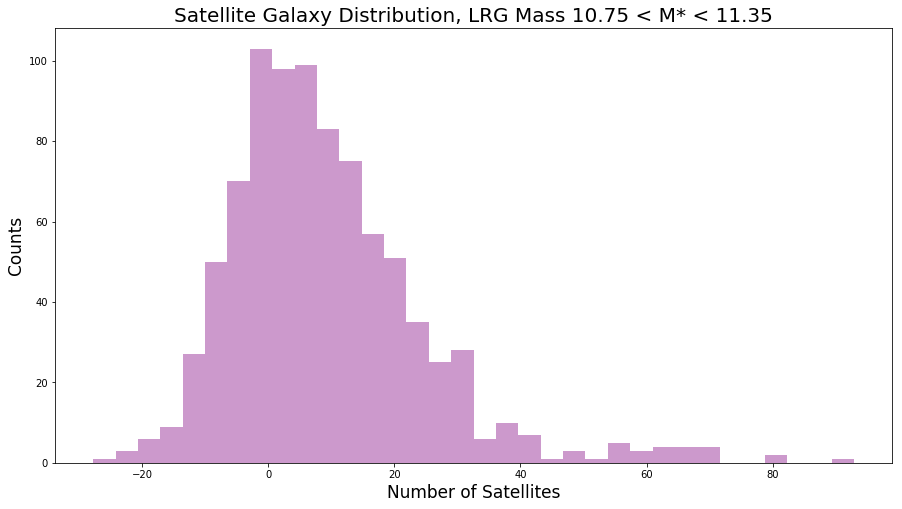

In [51]:
print(np.median(sumsat_mstar2))

sns.distplot(sumsat_mstar2, kde=False, color='purple')
plt.title('Satellite Galaxy Distribution, LRG Mass 10.75 < M* < 11.35', fontsize=20)
plt.xlabel('Number of Satellites', fontsize=17)
plt.ylabel('Counts', fontsize=17)
plt.savefig('/Users/mtownsend/Desktop/Nsat-dist-mstar2_v1.pdf')
plt.savefig('/Users/mtownsend/Desktop/Nsat-dist-mstar2_v1.jpg')


10.179917595400635


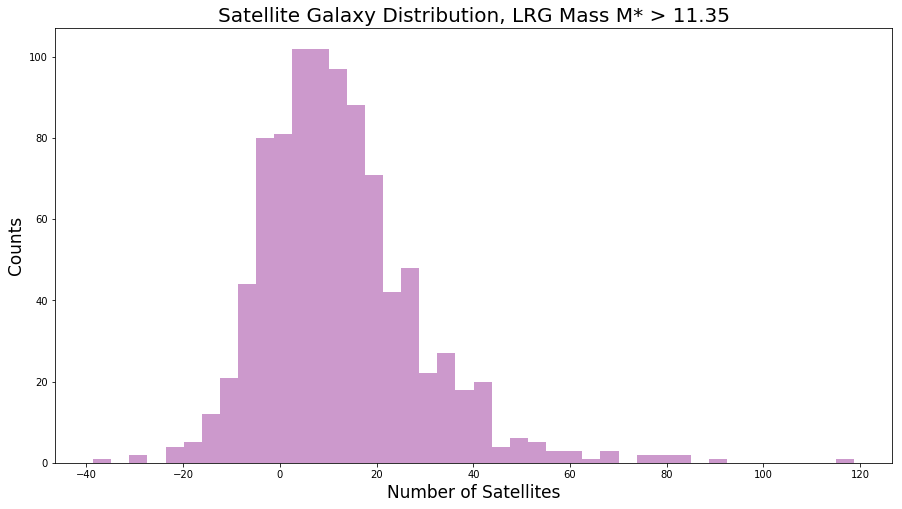

In [52]:
print(np.median(sumsat_mstar3))

sns.distplot(sumsat_mstar3, kde=False, color='purple')
plt.title('Satellite Galaxy Distribution, LRG Mass M* > 11.35', fontsize=20)
plt.xlabel('Number of Satellites', fontsize=17)
plt.ylabel('Counts', fontsize=17)
plt.savefig('/Users/mtownsend/Desktop/Nsat-dist-mstar3_v1.pdf')
plt.savefig('/Users/mtownsend/Desktop/Nsat-dist-mstar3_v1.jpg')


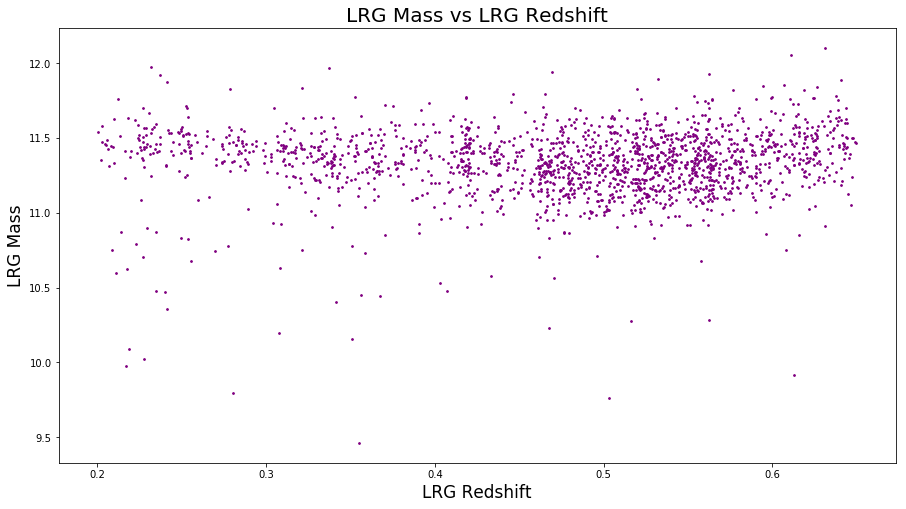

In [59]:
plt.scatter(z_LRG, mstar[idx], color='purple', s=3)
plt.title('LRG Mass vs LRG Redshift', fontsize=20)
plt.xlabel('LRG Redshift', fontsize=17)
plt.ylabel('LRG Mass', fontsize=17)
plt.savefig('/Users/mtownsend/Desktop/LRGmass-v-LRGz_v1.pdf')
plt.savefig('/Users/mtownsend/Desktop/LRGmass-v-LRGz_v1.jpg')


In [66]:
sumsat_mstar1 = sumsat[np.where((mstar[idx] < 10.75))]
sumsat_mstar2 = sumsat[np.where((mstar[idx] >= 10.75) & (mstar[idx] < 11.))]
sumsat_mstar3 = sumsat[np.where((mstar[idx] >= 11.0) & (mstar[idx] < 11.25))]
sumsat_mstar4 = sumsat[np.where((mstar[idx] >= 11.25) & (mstar[idx] < 11.5))]
sumsat_mstar5 = sumsat[np.where((mstar[idx] >= 11.5))]

print(len(sumsat_mstar1))
print(len(sumsat_mstar2))
print(len(sumsat_mstar3))
print(len(sumsat_mstar4))
print(len(sumsat_mstar5))

med_mstar1 = np.median(sumsat_mstar1)
med_mstar2 = np.median(sumsat_mstar2)
med_mstar3 = np.median(sumsat_mstar3)
med_mstar4 = np.median(sumsat_mstar4)
med_mstar5 = np.median(sumsat_mstar5)

print(med_mstar1)
print(med_mstar2)
print(med_mstar3)
print(med_mstar4)
print(med_mstar5)

mean_mstar1 = np.mean(sumsat_mstar1)
mean_mstar2 = np.mean(sumsat_mstar2)
mean_mstar3 = np.mean(sumsat_mstar3)
mean_mstar4 = np.mean(sumsat_mstar4)
mean_mstar5 = np.mean(sumsat_mstar5)

print(mean_mstar1)
print(mean_mstar2)
print(mean_mstar3)
print(mean_mstar4)
print(mean_mstar5)

32
60
434
944
353
7.609594329425361
7.118885360753085
6.229840118276291
8.862550247796602
10.69685086597403
9.561369930777584
8.895352095594996
8.444373367381486
11.079238362746477
13.868339382444466


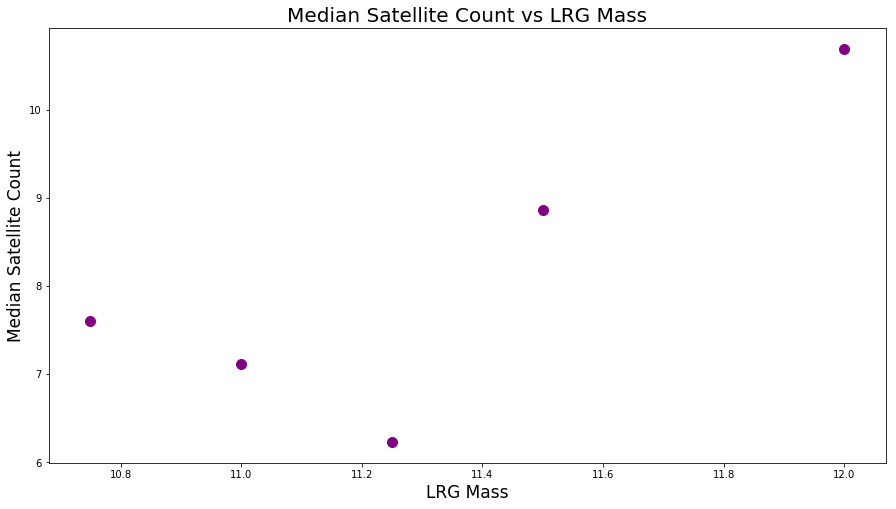

In [68]:
mstar_bins = np.array([10.75, 11, 11.25, 11.5, 12])
median_bins = np.array([med_mstar1, med_mstar2, med_mstar3, med_mstar4, med_mstar5])

plt.scatter(mstar_bins, median_bins, color='purple', s=100)
plt.title('Median Satellite Count vs LRG Mass', fontsize=20)
plt.xlabel('LRG Mass', fontsize=17)
plt.ylabel('Median Satellite Count', fontsize=17)
plt.savefig('/Users/mtownsend/Desktop/LRGmass-v-MedSatCount_v1.pdf')
plt.savefig('/Users/mtownsend/Desktop/LRGmass-v-MedSatCount_v1.jpg')


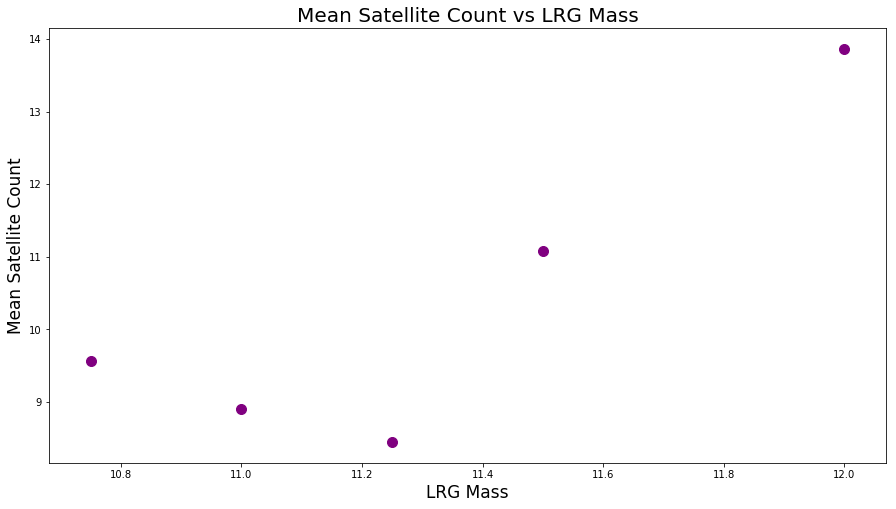

In [70]:
mstar_bins = np.array([10.75, 11, 11.25, 11.5, 12])
mean_bins = np.array([mean_mstar1, mean_mstar2, mean_mstar3, mean_mstar4, mean_mstar5])

plt.scatter(mstar_bins, mean_bins, color='purple', s=100)
plt.title('Mean Satellite Count vs LRG Mass', fontsize=20)
plt.xlabel('LRG Mass', fontsize=17)
plt.ylabel('Mean Satellite Count', fontsize=17)
plt.savefig('/Users/mtownsend/Desktop/LRGmass-v-MeanSatCount_v1.pdf')
plt.savefig('/Users/mtownsend/Desktop/LRGmass-v-MeanSatCount_v1.jpg')
